# Setup

Dhrumil's standard Python + R Setup. This setup allows me to use python and R in the same notebook. 

See https://github.com/data4news/jupyter-quickstart for details.

In [13]:
# %reload_ext rpy2.ipython
%reload_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
# from rpy2.rinterface import RRuntimeWarning
# warnings.filterwarnings("ignore", category=RRuntimeWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, HTML
from datetime import datetime, date, timedelta
from tqdm.notebook import tqdm
## import os; os.makedirs('output', exist_ok=True)

Install new mediacloud client (you may need to uninstall the old one if you have it already) and the wayback-news-search client.

In [5]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## New MediaCloud

In [29]:
import datetime as dt
from waybacknews.searchapi import SearchApiClient

In [30]:
from mediacloud import api

# Query parameters
query_term = "(title:Musk OR title:DOGE)"
start =  datetime(2025, 2, 10)
end = datetime.today()
language = "en"

domains = ['nytimes.com','cnn.com','foxnews.com','nypost.com','washingtonpost.com','usatoday.com','cnbc.com',
              'theguardian.com','breakingnews.com','buzzfeed.com','cbsnews.com','reuters.com','huffingtonpost.com',
              'usnews.com','latimes.com','politico.com','newsweek.com','breitbart.com',]
domains_str = f"domain:({' OR '.join(domains)})"

query = f"{query_term} AND language:{language} AND {domains_str}"
query

'(title:Musk OR title:DOGE) AND language:en AND domain:(nytimes.com OR cnn.com OR foxnews.com OR nypost.com OR washingtonpost.com OR usatoday.com OR cnbc.com OR theguardian.com OR breakingnews.com OR buzzfeed.com OR cbsnews.com OR reuters.com OR huffingtonpost.com OR usnews.com OR latimes.com OR politico.com OR newsweek.com OR breitbart.com)'

In [31]:
import json
import os

# Ensure the output directory exists
os.makedirs('output', exist_ok=True)

# Save Metadata
metadata = {
    "start": start.isoformat(), 
    "end": end.isoformat(),
    "query": query_term,
    "query_raw": query
}

# Save to json file
with open('output/metadata.json', 'w') as fp:
    json.dump(metadata, fp)

In [32]:
# Instantiate API
api = SearchApiClient("mediacloud")

In [33]:
# Run Summary Queries
count   = api.count(query, start, end)
sources = api.top_sources(query, start, end)
tlds    = api.top_tlds(query, start, end)

In [34]:
# Display Query
pattern = '%B %d, %Y %H:%M'
display(HTML("<h3>Query</h3>"))
print(query)
print(f"{start.strftime(pattern)} - {end.strftime(pattern)}")

# Display Summaries of Results
n = 25
display(HTML("<h3>Summary of results</h3>"))
print(f"Found {count} articles\n")
display(pd.DataFrame(sources).head(n).style.set_caption(f"Top {n} sources"))
display(pd.DataFrame(tlds).head(n).style.set_caption(f"Top {n} tlds"))

(title:Musk OR title:DOGE) AND language:en AND domain:(nytimes.com OR cnn.com OR foxnews.com OR nypost.com OR washingtonpost.com OR usatoday.com OR cnbc.com OR theguardian.com OR breakingnews.com OR buzzfeed.com OR cbsnews.com OR reuters.com OR huffingtonpost.com OR usnews.com OR latimes.com OR politico.com OR newsweek.com OR breitbart.com)
February 10, 2025 00:00 - March 07, 2025 23:29


Found 774 articles



,name,value
0,cbsnews.com,133
1,foxnews.com,125
2,newsweek.com,105
3,nypost.com,77
4,breitbart.com,65
5,cnn.com,57
6,usatoday.com,51
7,nytimes.com,48
8,theguardian.com,37
9,cnbc.com,31


,name,value
0,com,774


### Get counts over time

In [35]:
counts_over_time = pd.DataFrame(api.count_over_time(query, start, end))
counts_over_time.to_csv('output/counts_over_time.csv', index=False)

In [36]:
%%R

require('tidyverse')

UsageError: Cell magic `%%R` not found.


── Attaching core tidyquant packages ──────────────────────── tidyquant 1.0.9 ──
✔ PerformanceAnalytics 2.0.4      ✔ TTR                  0.24.4
✔ quantmod             0.4.26     ✔ xts                  0.14.0
── Conflicts ────────────────────────────────────────── tidyquant_conflicts() ──
✖ zoo::as.Date()                 masks base::as.Date()
✖ zoo::as.Date.numeric()         masks base::as.Date.numeric()
✖ dplyr::filter()                masks stats::filter()
✖ xts::first()                   masks dplyr::first()
✖ dplyr::lag()                   masks stats::lag()
✖ xts::last()                    masks dplyr::last()
✖ PerformanceAnalytics::legend() masks graphics::legend()
✖ quantmod::summary()            masks base::summary()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
[1] "(title:Kamala OR title:Trump) AND language:en AND domain:(nytimes.com OR cnn.com OR foxnews.com OR nypost.com OR washingtonpost.com OR usatoday.com OR cnbc.co

Loading required package: tidyquant
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


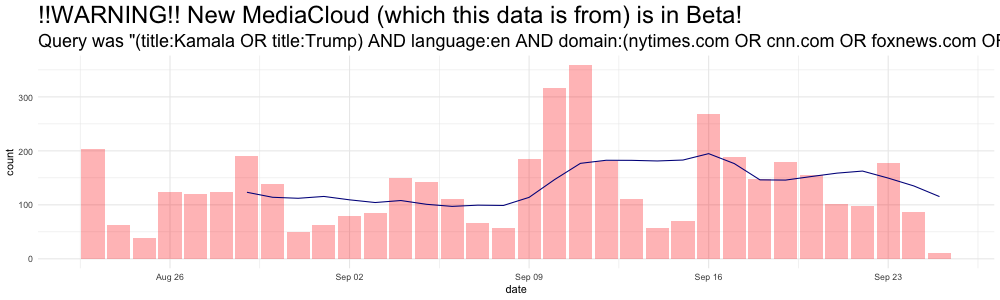

In [11]:
%%R -w 1000 -h 300 -i query

require('tidyquant')

counts_over_time <- read_csv('output/counts_over_time.csv', show_col_types = FALSE)

plt <- ggplot(counts_over_time) +
    aes(x=date, y=count) +
    geom_col(alpha=.3, fill="red") +
    geom_ma(ma_fun = SMA, n = 7, linetype='solid') +
    theme_minimal() +
    labs(
        subtitle=paste0("Query was \"",query,"\""),
        title="!!WARNING!! New MediaCloud (which this data is from) is in Beta! "
    ) +
    theme(
        plot.title = element_text(size=24),
        plot.subtitle = element_text(size=18))

print(plt)
print(query)

### Get actual articles

In [37]:
query 

'(title:Musk OR title:DOGE) AND language:en AND domain:(nytimes.com OR cnn.com OR foxnews.com OR nypost.com OR washingtonpost.com OR usatoday.com OR cnbc.com OR theguardian.com OR breakingnews.com OR buzzfeed.com OR cbsnews.com OR reuters.com OR huffingtonpost.com OR usnews.com OR latimes.com OR politico.com OR newsweek.com OR breitbart.com)'

In [38]:
article_generator = api.all_articles(query, start, end)

In [39]:
# TODO: Add a progress bar
# took 1m 4.6s for 37998 articles 
# ChatGPT AND language:en from (2022-11-01 to 2023-3-23)
articles = []
for list_of_articles in article_generator:
    articles += list_of_articles    

print(f"all_articles endpoint: {len(articles)} articles")
print(f"count endpoint: {count} articles")

all_articles endpoint: 774 articles
count endpoint: 774 articles


In [40]:
stories = pd.DataFrame(articles)\
        .sort_values(by='publication_date', ascending=False)

stories.to_csv('output/stories_df.csv', index=False)

stories

,title,publication_date,capture_time,language,domain,url,original_capture_url,archive_playback_url,article_url
290,Elon Musk,2025-03-05,2025-03-05T17:44:22Z,en,foxnews.com,https://www.foxnews.com/category/person/elon-musk,https://web.archive.org/web/20250305174422id_/...,https://web.archive.org/web/20250305174422/htt...,https://wayback-api.archive.org/colsearch/v1/m...
231,Social Security has never missed a payment. DO...,2025-03-01,2025-03-05T23:14:15Z,en,cnbc.com,https://www.cnbc.com/2025/03/01/doge-actions-m...,https://web.archive.org/web/20250305231415id_/...,https://web.archive.org/web/20250305231415/htt...,https://wayback-api.archive.org/colsearch/v1/m...
656,Musk and Republican Lawmakers Pressure Judges ...,2025-03-01,2025-03-05T10:49:58Z,en,nytimes.com,https://www.nytimes.com/2025/03/01/us/politics...,https://web.archive.org/web/20250305104958id_/...,https://web.archive.org/web/20250305104958/htt...,https://wayback-api.archive.org/colsearch/v1/m...
655,The Bewildering Irony Behind the Trump-Musk Pa...,2025-02-27,2025-03-05T19:47:03Z,en,nytimes.com,https://www.nytimes.com/2025/02/27/opinion/tru...,https://web.archive.org/web/20250305194703id_/...,https://web.archive.org/web/20250305194703/htt...,https://wayback-api.archive.org/colsearch/v1/m...
230,"Trump, Musk float idea of $5,000 'DOGE dividen...",2025-02-27,2025-03-05T23:14:15Z,en,cnbc.com,https://www.cnbc.com/2025/02/27/trump-musk-pro...,https://web.archive.org/web/20250305231415id_/...,https://web.archive.org/web/20250305231415/htt...,https://wayback-api.archive.org/colsearch/v1/m...
...,...,...,...,...,...,...,...,...,...
536,Elon Musk-led group makes shock $97.4B bid for...,2025-02-10,2025-02-11T14:21:33Z,en,nypost.com,https://nypost.com/2025/02/10/business/elon-mu...,https://web.archive.org/web/20250211142133id_/...,https://web.archive.org/web/20250211142133/htt...,https://wayback-api.archive.org/colsearch/v1/m...
233,"DOGE targets federal leases, shaking commercia...",2025-02-10,2025-02-11T07:31:56Z,en,cnn.com,https://www.cnn.com/2025/02/10/business/return...,https://web.archive.org/web/20250211073156id_/...,https://web.archive.org/web/20250211073156/htt...,https://wayback-api.archive.org/colsearch/v1/m...
234,Musk charges on with new targets in sight and ...,2025-02-10,2025-02-11T18:53:27Z,en,cnn.com,https://www.cnn.com/2025/02/10/politics/musk-t...,https://web.archive.org/web/20250211185327id_/...,https://web.archive.org/web/20250211185327/htt...,https://wayback-api.archive.org/colsearch/v1/m...
526,"Trump orders halt on ""wasteful"" pennies after ...",2025-02-10,2025-02-11T09:51:31Z,en,newsweek.com,https://www.newsweek.com/trump-orders-halt-was...,https://web.archive.org/web/20250211095131id_/...,https://web.archive.org/web/20250211095131/htt...,https://wayback-api.archive.org/colsearch/v1/m...


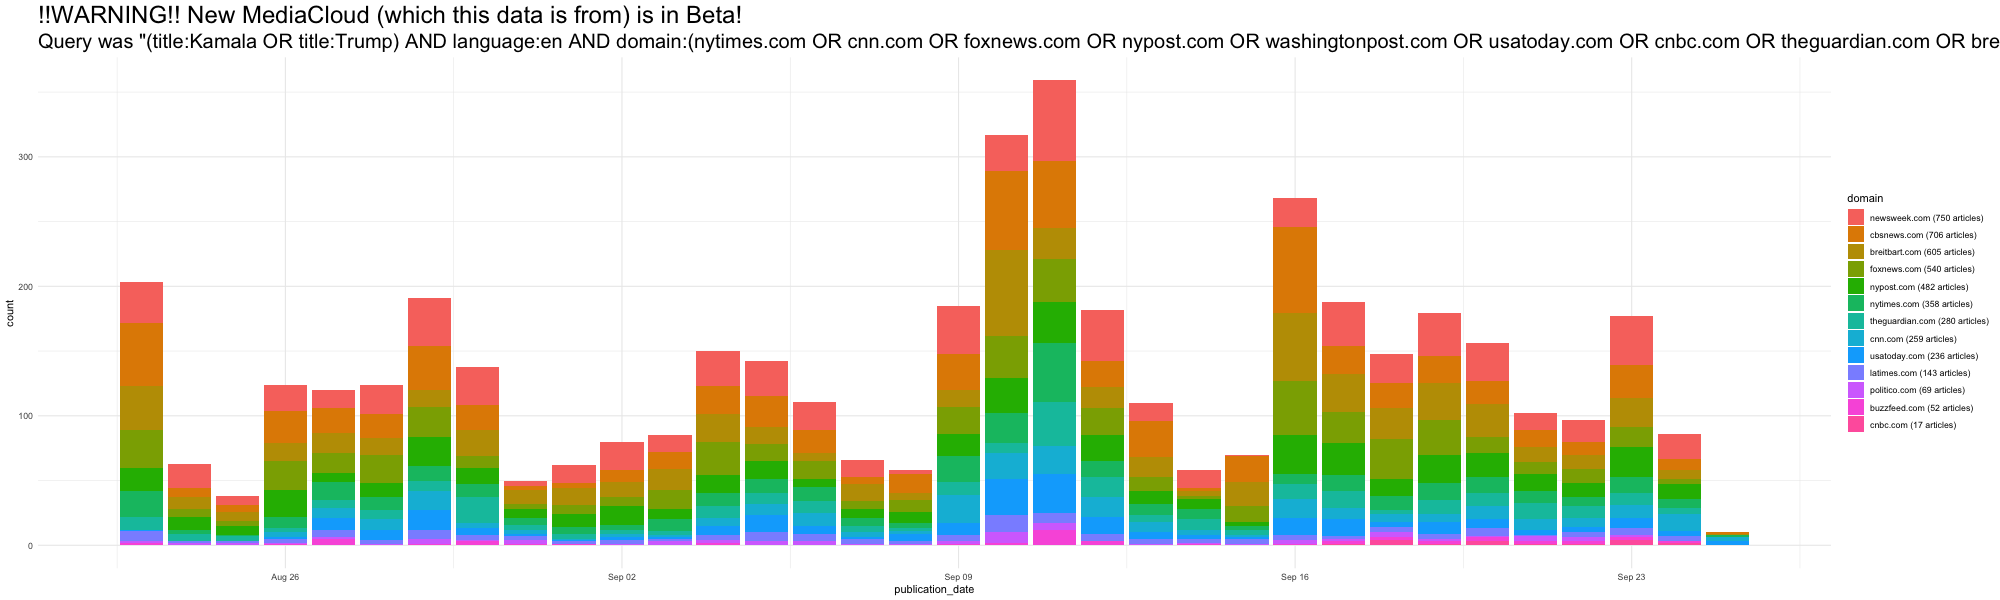

In [16]:
%%R -w 2000 -h 600 

stories_df <- read_csv('output/stories_df.csv', show_col_types = FALSE)
domain_order <- stories_df %>% group_by(domain) %>% summarise(count=n()) %>% arrange(desc(count))
domain_order$label <- paste0(domain_order$domain, ' (', domain_order$count,' articles)') 
stories_df$domain <- factor(stories_df$domain, levels=domain_order$domain, labels=domain_order$label)


ggplot(stories_df) +
    aes(x=publication_date, fill=domain) +
    geom_bar() +
    theme_minimal() +
    labs(
        subtitle=paste0("Query was \"",query,"\""),
        title="!!WARNING!! New MediaCloud (which this data is from) is in Beta! "
    ) +
    theme(
        plot.title = element_text(size=24),
        plot.subtitle = element_text(size=20),
        strip.text = element_text(size=18))

`summarise()` has grouped output by 'domain'. You can override using the
`.groups` argument.


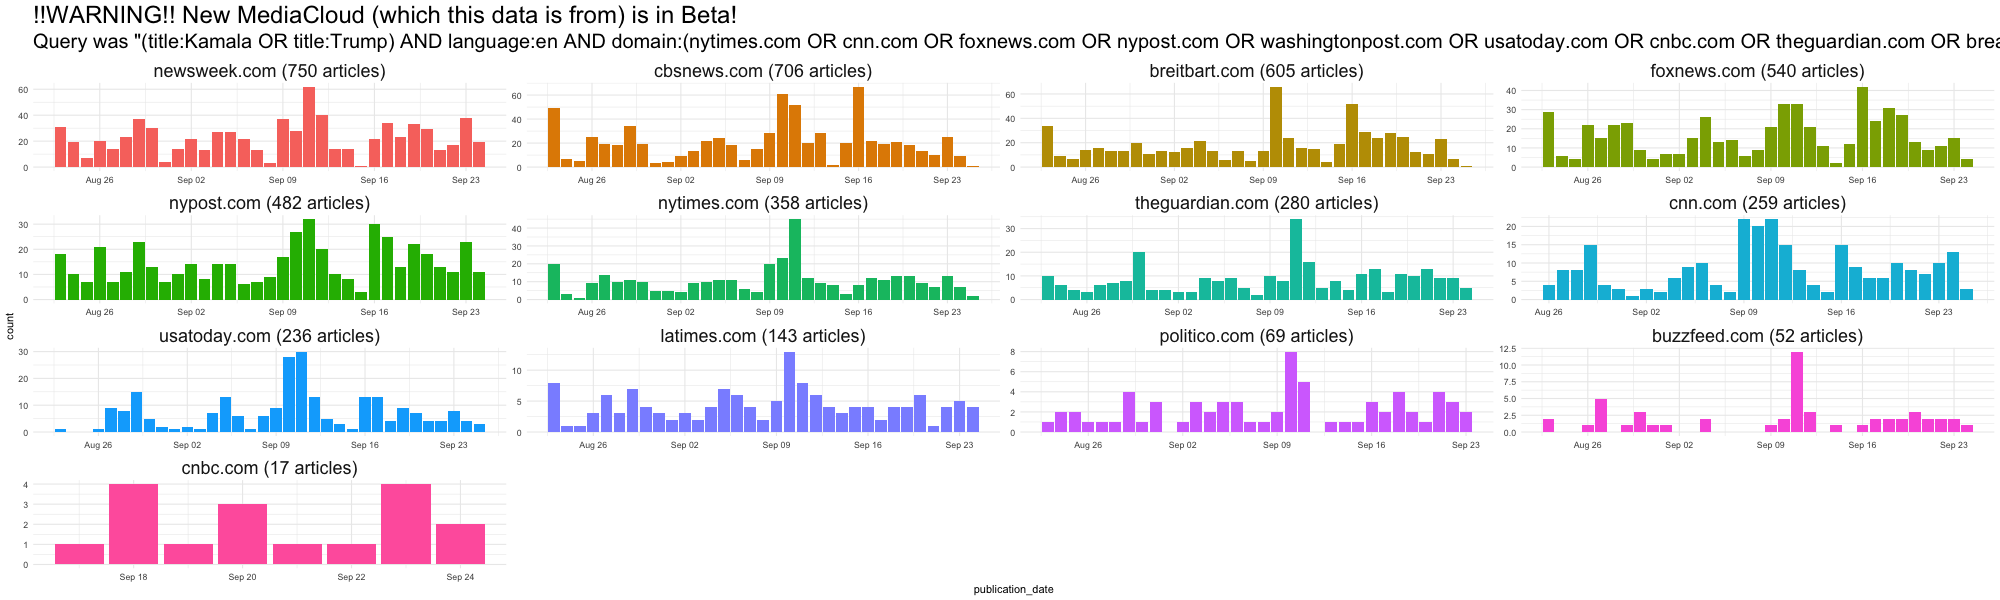

In [17]:
%%R -w 2000 -h 600 

stories_df <- read_csv('output/stories_df.csv', show_col_types = FALSE)
domain_order <- stories_df %>% group_by(domain) %>% summarise(count=n()) %>% arrange(desc(count))
domain_order$label <- paste0(domain_order$domain, ' (', domain_order$count,' articles)') 
stories_df$domain <- factor(stories_df$domain, levels=domain_order$domain, labels=domain_order$label)

stories_df_2 <- stories_df %>% group_by(domain, publication_date) %>% summarise(count=n()) %>% arrange(desc(count))
ggplot(stories_df_2) +
    aes(x=publication_date, y=count, fill=domain) +
    geom_col() +
    facet_wrap(~domain, scales='free') +
    theme_minimal() +
    labs(
        subtitle=paste0("Query was \"",query,"\""),
        title="!!WARNING!! New MediaCloud (which this data is from) is in Beta! "
    ) +
    theme(
        plot.title = element_text(size=24),
        plot.subtitle = element_text(size=20),
        strip.text = element_text(size=18),
        legend.position="none")

In [41]:
import requests_cache
session = requests_cache.CachedSession('mediacloud_cache')

from tqdm.autonotebook import tqdm
tqdm.pandas()

# retrying
from retrying import retry
stories = pd.read_csv('output/stories_df.csv')

@retry(wait_exponential_multiplier=1000, wait_exponential_max=10000)
def get_snippet(url):
    return session.get(url).json()['snippet']

stories['snippet'] = stories['article_url'].progress_apply(get_snippet)

/var/folders/kn/rwt3lmvn7gs3vl38bv_ppttw0000gr/T/ipykernel_99544/3023998073.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/774 [00:00<?, ?it/s]

In [42]:
# Stories with full text of articles!!!!
stories_df = pd.DataFrame(stories)
stories_df.to_csv('output/stories_df.csv', index=False)
stories_df.sample(4)

,title,publication_date,capture_time,language,domain,url,original_capture_url,archive_playback_url,article_url,snippet
431,Country singer dumps Tesla after expressing di...,2025-02-15,2025-02-16T07:40:00Z,en,newsweek.com,https://www.newsweek.com/entertainment/celebri...,https://web.archive.org/web/20250216074000id_/...,https://web.archive.org/web/20250216074000/htt...,https://wayback-api.archive.org/colsearch/v1/m...,Sheryl Crow is parting ways with her Tesla — a...
22,"Watchdog group sues for DOGE records, arguing ...",2025-02-21,2025-02-23T01:57:21Z,en,cbsnews.com,https://www.cbsnews.com/news/watchdog-group-su...,https://web.archive.org/web/20250223015721id_/...,https://web.archive.org/web/20250223015721/htt...,https://wayback-api.archive.org/colsearch/v1/m...,"Watchdog group sues for DOGE records, arguing ..."
619,‘Obama Bros’ admit they should’ve done ‘some o...,2025-02-12,2025-02-13T19:14:47Z,en,nypost.com,https://nypost.com/2025/02/12/us-news/obama-br...,https://web.archive.org/web/20250213191447id_/...,https://web.archive.org/web/20250213191447/htt...,https://wayback-api.archive.org/colsearch/v1/m...,‘Obama Bros’ admit they should’ve done ‘some o...
242,Men claiming to be from DOGE at San Francisco ...,2025-02-18,2025-02-20T12:58:06Z,en,cbsnews.com,https://www.cbsnews.com/sanfrancisco/news/men-...,https://web.archive.org/web/20250220125806id_/...,https://web.archive.org/web/20250220125806/htt...,https://wayback-api.archive.org/colsearch/v1/m...,Men claiming to be from DOGE at San Francisco ...
